In [2]:
from importlib import reload
from src import mix
import pandas as pd
import numpy as np
import scprep
import os
import scanpy as sc
import phate
import meld

In [3]:
# Path to the original MELD Zebrafish dataset
filepath = os.path.join("./data", "Klein2018_Zebrafish.h5ad")

In [ ]:
# Download if not already
URL = "https://ndownloader.figshare.com/files/25687247?private_link=f194ae7d6bcec9bd11a3"
scprep.io.download.download_url(URL, filepath)

In [4]:
# Read in the Zebrafish dataset and take a subsample - for testing purposes we can operate on only a fraction of the dataset
subsample_size = 1000

adata = sc.read_h5ad(filepath)
subsample_index = np.random.choice(adata.shape[0], size=subsample_size, replace=False)
adata = adata[subsample_index].copy()

/Users/montyevans/opt/miniconda3/envs/meld/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Calculating PHATE...
  Running PHATE on 1000 observations and 29197 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.16 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.09 seconds.
    Calculating affinities...
    Calculated affinities in 0.03 seconds.
  Calculated graph and diffusion operator in 1.30 seconds.
  Calculating optimal t...
    Automatically selected t = 24
  Calculated optimal t in 0.37 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.11 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.97 seconds.
Calculated PHATE in 2.75 seconds.


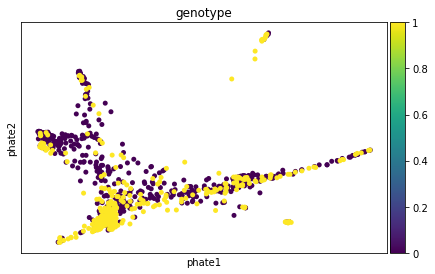

In [5]:
# Calculate the Phate components for the sample... I think?

metadata = adata.obs
metadata['genotype'] = np.where(metadata['sample_labels'].str.startswith("chd"), 0, 1)
sc.pp.pca(adata, n_comps=50) 
sc.pp.neighbors(adata, n_neighbors= 10)

phate_op = phate.PHATE(n_components=2, knn=10, decay = 40, n_jobs = 8)
X_phate = phate_op.fit_transform(adata)
adata.obsm['X_phate'] = X_phate #housed in osbm because embedding

sc.pl.scatter(adata, basis = 'phate', color = 'genotype', size = 100)

In [33]:
# Run vanilla MELD on the sample

meld_op = meld.MELD(beta=67, knn=7)
sample_densities = meld_op.fit_transform(adata.obsm['X_pca'], sample_labels=metadata['genotype'])
adata.obs["meld_labels"] = sample_densities[0]

adata_meld = sample_densities.set_index(adata.obs['mix_labels'].index)
adata.obs["meld_labels"] = adata_meld[1]

Building graph on 1000 samples and 50 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.08 seconds.
  Calculating affinities...
Calculated graph and diffusion operator in 0.12 seconds.


In [40]:
# Reload our library to bring in any changes, and then run MIX for comparison to MELD

reload(mix)
mix.MIX_daniel(adata, diffusion_level=1, input_obs="genotype")
mix.MIX_monty(adata, num_steps = 10000, alpha=0.15, input_obs="genotype", output_obs="mix_labels_monty")

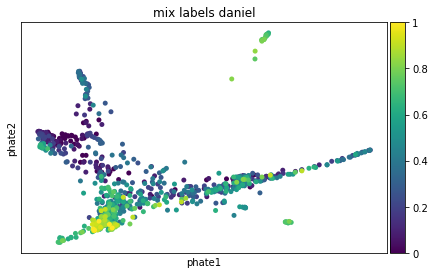

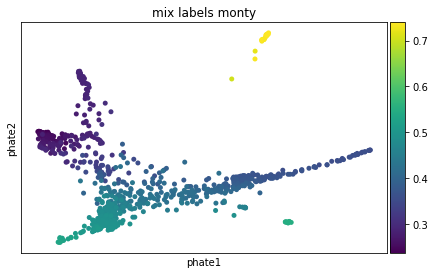

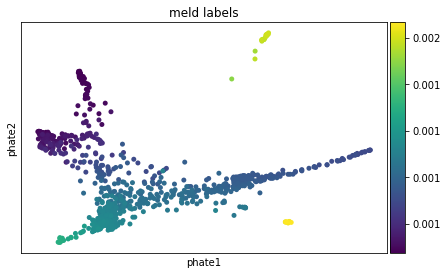

In [41]:
sc.pl.scatter(adata, basis = 'phate', color = 'mix_labels_daniel', size = 100)
sc.pl.scatter(adata, basis = 'phate', color='mix_labels_monty', size = 100)
sc.pl.scatter(adata, basis = 'phate', color='meld_labels', size = 100)